<a href="https://colab.research.google.com/github/rujool11/ML-learning/blob/main/Projects/Food101/Food101Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision # need to use GPU with compute capability over 7 (T4 in this case, with 7.5)

In [ ]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import plot_loss_curves, compare_historys

--2023-10-18 15:53:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-18 15:53:38 (57.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



### **load datasets from tensorflow datasets**

In [ ]:
import tensorflow_datasets as tfds
datasets_list = tfds.list_builders()
print('food101' in datasets_list)

True


In [ ]:
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True, # data returned as (data, label)
                                             with_info=True) # for metadata

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete8QYC09/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete8QYC09/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


### **data exploration**

In [ ]:
ds_info.features # image and label with image tensor and label

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features['label'].names
class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [ ]:
train_sample = train_data.take(1) # takes one sample from train data
train_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image, label in train_sample:
  print(f'''
  image_shape : {image.shape}
  image_datatype : {image.dtype}
  target_class : {label}
  class_name : {class_names[label.numpy()]}
  '''
  )

  # we can see that data is not one hot encoded


  image_shape : (341, 512, 3)
  image_datatype : <dtype: 'uint8'>
  target_class : 98
  class_name : tiramisu
  


In [ ]:
image

<tf.Tensor: shape=(306, 512, 3), dtype=uint8, numpy=
array([[[199, 100,  15],
        [192,  91,   9],
        [202,  95,  23],
        ...,
        [238, 196, 124],
        [237, 195, 123],
        [236, 194, 122]],

       [[210, 110,  25],
        [207, 105,  23],
        [194,  86,  13],
        ...,
        [238, 196, 124],
        [236, 194, 122],
        [235, 193, 121]],

       [[205, 103,  18],
        [213, 108,  25],
        [196,  86,  11],
        ...,
        [238, 195, 126],
        [237, 194, 125],
        [235, 192, 123]],

       ...,

       [[ 95,  28,  11],
        [ 94,  27,  10],
        [ 84,  17,   0],
        ...,
        [166,  32,   5],
        [166,  32,   3],
        [167,  34,   1]],

       [[ 87,  24,   7],
        [ 83,  18,   0],
        [ 87,  20,   1],
        ...,
        [155,  27,   0],
        [164,  39,   9],
        [156,  33,   0]],

       [[ 83,  21,   6],
        [ 79,  16,   0],
        [ 85,  19,   0],
        ...,
        [149,  25,   

In [ ]:
tf.reduce_min(image), tf.reduce_max(image) # min value 0 and max value 255

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

(-0.5, 511.5, 305.5, -0.5)

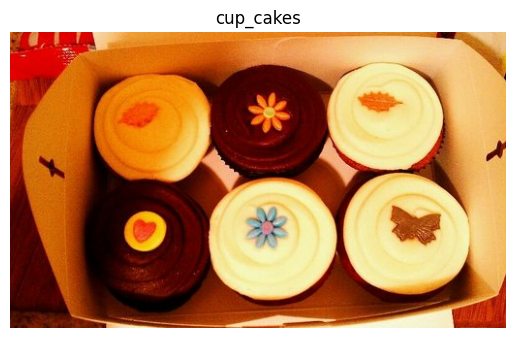

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

In [ ]:
len(train_data)

75750

### **Preprocessing functions**

data: unscaled, uint8, tensors of different form

models: scales, float32/float16, all tensors within a batch of same size

Efficientnetv2BX -- have rescaling built in (?) check


In [ ]:
def preprocess_img(image, label, img_shape=224, scale=False):
  '''
  convert dtype from unit8 to float32, and
  change shape to [img_shape, img_shape, color_channels]
  '''
  image = tf.image.resize(image, [img_shape,img_shape])
  if scale:
    image = image/255.
  return tf.cast(image, tf.float32), label


In [ ]:
prep_img, prep_label = preprocess_img(image, label)
print(f'before:\n {image[:2]}\n shape: {image.shape}\n datatype: {image.dtype}')
print(f'after\n {prep_img[:2]}\n shape: {prep_img.shape}\n datatype: {prep_img.dtype}')


before:
 [[[2 2 0]
  [2 2 0]
  [2 2 0]
  ...
  [0 3 0]
  [0 4 0]
  [0 4 0]]

 [[2 2 0]
  [2 2 0]
  [3 3 1]
  ...
  [1 3 0]
  [0 4 0]
  [0 4 0]]]
 shape: (341, 512, 3)
 datatype: <dtype: 'uint8'>
after
 [[[2.         2.         0.        ]
  [2.947226   2.947226   0.947226  ]
  [4.         5.         0.        ]
  ...
  [1.         3.         0.        ]
  [0.01865775 2.757497   0.        ]
  [0.         4.         0.        ]]

 [[4.350446   5.1339283  0.7834821 ]
  [4.566964   5.350446   1.        ]
  [4.783482   5.783482   0.7834821 ]
  ...
  [1.         3.         0.        ]
  [0.7989505  2.7989504  0.        ]
  [0.         4.2798424  0.27984235]]]
 shape: (224, 224, 3)
 datatype: <dtype: 'float32'>


### **Batch and prepare datasets**

In [ ]:
# batch and prepare datastets
# previously we used image_dataset_from_directory which batched datasets for us

train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE) # will map all data to preprocess_img
# AUTOTUNE will utilize as many CPU chips as it can, used to parallelize
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
# reshuffle for safety
# buffer size is how many examples to shuffle at a particular time, ideally would be len(train_data), but memory issues

test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

# these are all best practices to more efficiently process data, speed it up
# tf data performance guide best practises
# use cache() to load up data faster, but only if you have a lot of RAM


In [ ]:
train_data, test_data


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
len(train_data)

2368

In [ ]:
for image,_ in train_data.take(1):
  print(image.shape)

(32, 224, 224, 3)


### **Create callbacks**

In [ ]:
checkpoint_path = 'model_checkpoints/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_accuracy',
                                                      save_weights_only=True,
                                                      verbose=0, # dont print anything when saving
                                                      save_best_only=True)


### **Setting up mixed precision training**

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16') # set global data policy
# remember to set output back to float32 since it may not be numerically stable

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # preprocessing.rescale(1./255), efficientnet already rescales, so commented out
], name='data_augmentation')

### **Building our model**

In [ ]:
from tensorflow.keras import layers

input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype='float32', name='softmax_float32')(x)

model = tf.keras.Model(inputs, outputs)


model.compile(loss='sparse_categorical_crossentropy', # since labels are not one hot encoded
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy'])

24274472/24274472 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                             

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
data_augmentation True float32 <Policy "mixed_float16">
efficientnetv2-b0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


### **Training**


In [ ]:
hist = model.fit(train_data,
          epochs=4,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=int(0.15*len(test_data)),
          callbacks=[model_checkpoint])

Epoch 1/4
2368/2368 [==============================] - 593s 240ms/step - loss: 2.2275 - accuracy: 0.4678 - val_loss: 1.3021 - val_accuracy: 0.6515
Epoch 2/4
2368/2368 [==============================] - 315s 131ms/step - loss: 1.7247 - accuracy: 0.5623 - val_loss: 1.1881 - val_accuracy: 0.6793
Epoch 3/4
2368/2368 [==============================] - 245s 102ms/step - loss: 1.6027 - accuracy: 0.5916 - val_loss: 1.1455 - val_accuracy: 0.6827
Epoch 4/4
2368/2368 [==============================] - 218s 91ms/step - loss: 1.5351 - accuracy: 0.6049 - val_loss: 1.1209 - val_accuracy: 0.7007


In [ ]:
res = model.evaluate(test_data)

790/790 [==============================] - 53s 67ms/step - loss: 1.1245 - accuracy: 0.6930


In [ ]:
model.save('drive/MyDrive/Models/big_to_finetune.h5')

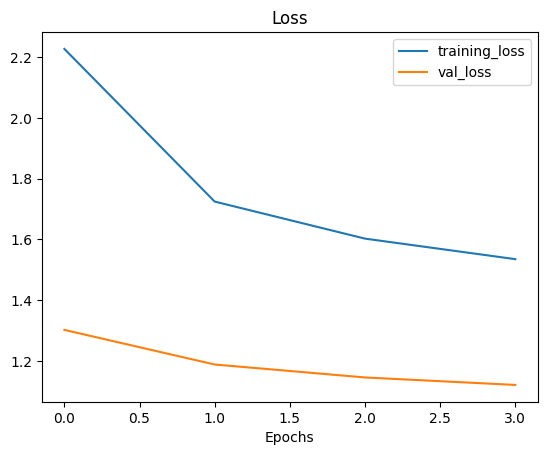

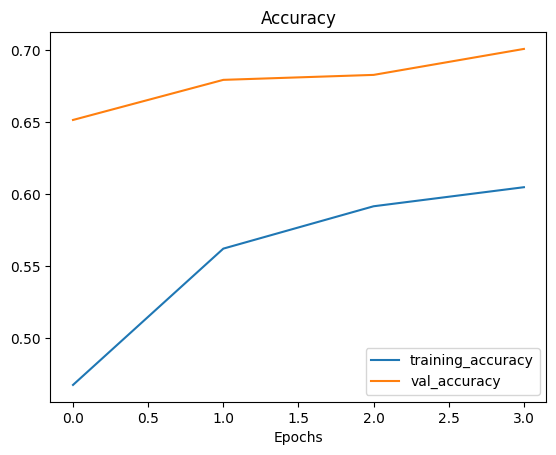

In [ ]:
plot_loss_curves(hist)

In [ ]:
loaded_model = tf.keras.models.load_model('drive/MyDrive/Models/big_to_finetune.h5')
load_res = loaded_model.evaluate(test_data)
load_res

790/790 [==============================] - 57s 70ms/step - loss: 1.1245 - accuracy: 0.6930


[1.1245063543319702, 0.6929504871368408]

In [ ]:
model = tf.keras.models.load_model('drive/MyDrive/Models/big_to_finetune.h5')
res = model.evaluate(test_data)

790/790 [==============================] - 65s 71ms/step - loss: 1.1245 - accuracy: 0.6930


In [ ]:
hist = model.fit(train_data,
                 epochs=8,
                 steps_per_epoch=len(train_data),
                 validation_data=test_data,
                 validation_steps=int(0.15*len(test_data)),
                 initial_epoch=4,
                 callbacks=[model_checkpoint])

Epoch 5/8
2368/2368 [==============================] - 572s 238ms/step - loss: 1.4847 - accuracy: 0.6172 - val_loss: 1.0826 - val_accuracy: 0.7052
Epoch 6/8
2368/2368 [==============================] - 320s 134ms/step - loss: 1.4385 - accuracy: 0.6275 - val_loss: 1.0814 - val_accuracy: 0.7142
Epoch 7/8
2368/2368 [==============================] - 271s 114ms/step - loss: 1.4050 - accuracy: 0.6349 - val_loss: 1.0668 - val_accuracy: 0.7082
Epoch 8/8
2368/2368 [==============================] - 211s 88ms/step - loss: 1.3938 - accuracy: 0.6368 - val_loss: 1.0718 - val_accuracy: 0.7026


In [ ]:
res = model.evaluate(test_data)

790/790 [==============================] - 52s 66ms/step - loss: 1.0778 - accuracy: 0.7079


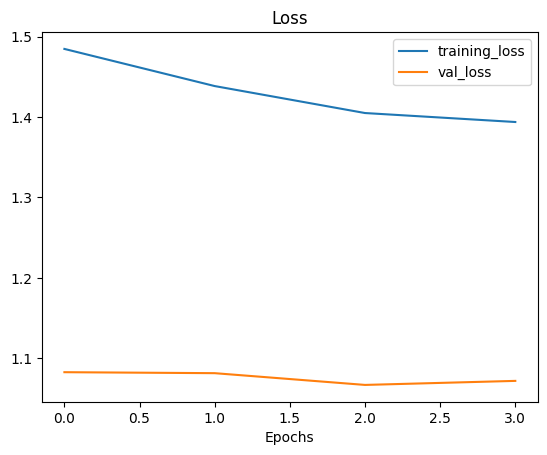

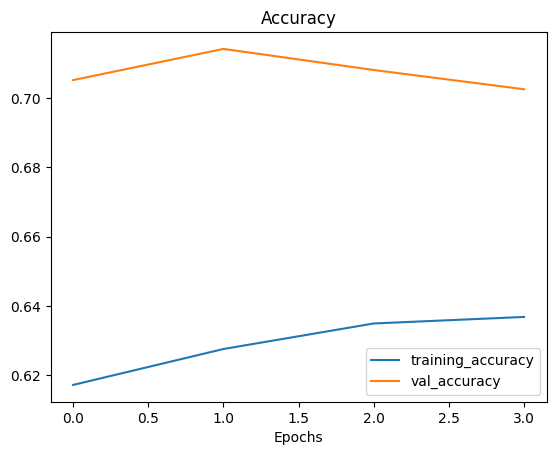

In [ ]:
plot_loss_curves(hist)

In [ ]:
model.save('drive/MyDrive/Models/big_to_finetune.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loaded_model = tf.keras.models.load_model('drive/MyDrive/Models/big_to_finetune.h5')
res_loaded = loaded_model.evaluate(test_data)
res_loaded

790/790 [==============================] - 57s 70ms/step - loss: 1.0778 - accuracy: 0.7079


[1.0778335332870483, 0.7078812122344971]

### **Fine tuning by unfreezing layers**

In [ ]:
### now go for fine tuning

model = tf.keras.models.load_model('drive/MyDrive/Models/big_to_finetune.h5')
res = model.evaluate(test_data)

790/790 [==============================] - 58s 71ms/step - loss: 1.0778 - accuracy: 0.7079


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                             

In [ ]:
model.layers[2].trainable = True
for layer in model.layers[2].layers[:-15]:
  layer.trainable = False

for layer in model.layers[2].layers:
  print(layer.name, ':', layer.trainable)


input_1 : False
rescaling : False
normalization : False
stem_conv : False
stem_bn : False
stem_activation : False
block1a_project_conv : False
block1a_project_bn : False
block1a_project_activation : False
block2a_expand_conv : False
block2a_expand_bn : False
block2a_expand_activation : False
block2a_project_conv : False
block2a_project_bn : False
block2b_expand_conv : False
block2b_expand_bn : False
block2b_expand_activation : False
block2b_project_conv : False
block2b_project_bn : False
block2b_drop : False
block2b_add : False
block3a_expand_conv : False
block3a_expand_bn : False
block3a_expand_activation : False
block3a_project_conv : False
block3a_project_bn : False
block3b_expand_conv : False
block3b_expand_bn : False
block3b_expand_activation : False
block3b_project_conv : False
block3b_project_bn : False
block3b_drop : False
block3b_add : False
block4a_expand_conv : False
block4a_expand_bn : False
block4a_expand_activation : False
block4a_dwconv2 : False
block4a_bn : False
block4

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
hist = model.fit(train_data,
          steps_per_epoch=len(train_data),hist = model.fit(train_data,
          steps_per_epoch=len(train_data),
          epochs=12,
          validation_data=test_data,
          validation_steps=int(0.15*len(test_data)),
          callbacks=[model_checkpoint],
          initial_epoch=8)
          epochs=12,
          validation_data=test_data,
          validation_steps=int(0.15*len(test_data)),
          callbacks=[model_checkpoint],
          initial_epoch=8)


Epoch 9/12
2368/2368 [==============================] - 571s 233ms/step - loss: 1.2453 - accuracy: 0.6706 - val_loss: 0.9937 - val_accuracy: 0.7304
Epoch 10/12
2368/2368 [==============================] - 323s 135ms/step - loss: 1.1660 - accuracy: 0.6916 - val_loss: 0.9632 - val_accuracy: 0.7328
Epoch 11/12
2368/2368 [==============================] - 260s 108ms/step - loss: 1.1194 - accuracy: 0.7023 - val_loss: 0.9305 - val_accuracy: 0.7410
Epoch 12/12
2368/2368 [==============================] - 216s 90ms/step - loss: 1.0697 - accuracy: 0.7121 - val_loss: 0.9321 - val_accuracy: 0.7442


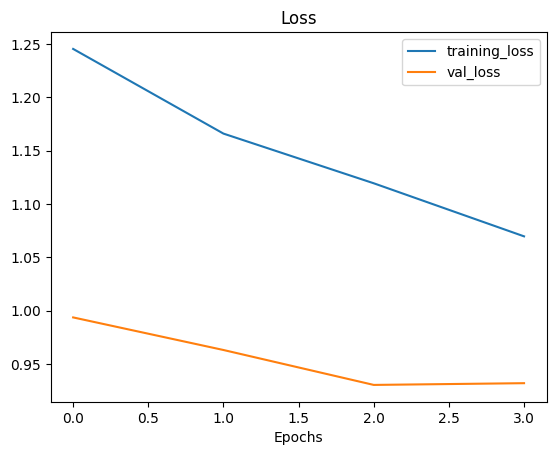

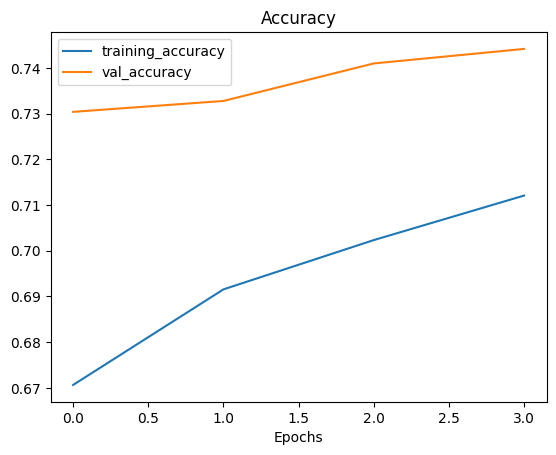

In [ ]:
plot_loss_curves(hist)

In [ ]:
res = model.evaluate(test_data)

790/790 [==============================] - 70s 89ms/step - loss: 0.9390 - accuracy: 0.7431


In [ ]:
model.save('drive/MyDrive/Models/big_fintetuned.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loaded_model = tf.keras.models.load_model('drive/MyDrive/Models/big_fintetuned.h5')
res_loaded = loaded_model.evaluate(test_data)

790/790 [==============================] - 65s 78ms/step - loss: 0.9390 - accuracy: 0.7431


In [ ]:
model = tf.keras.models.load_model('drive/MyDrive/Models/big_fintetuned.h5')
res = model.evaluate(test_data)

790/790 [==============================] - 68s 72ms/step - loss: 0.9390 - accuracy: 0.7431


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
hist = model.fit(train_data,
          steps_per_epoch=len(train_data),
          epochs=16,
          validation_data=test_data,
          validation_steps=int(0.15*len(test_data)),
          callbacks=[model_checkpoint],
          initial_epoch=12)

Epoch 13/16
2368/2368 [==============================] - 599s 242ms/step - loss: 1.0398 - accuracy: 0.7215 - val_loss: 0.9208 - val_accuracy: 0.7474
Epoch 14/16
2368/2368 [==============================] - 336s 140ms/step - loss: 0.9991 - accuracy: 0.7303 - val_loss: 0.9288 - val_accuracy: 0.7386
Epoch 15/16
2368/2368 [==============================] - 268s 111ms/step - loss: 0.9722 - accuracy: 0.7357 - val_loss: 0.8957 - val_accuracy: 0.7519
Epoch 16/16
2368/2368 [==============================] - 242s 100ms/step - loss: 0.9406 - accuracy: 0.7431 - val_loss: 0.8929 - val_accuracy: 0.7481


In [ ]:
res = model.evaluate(test_data)

790/790 [==============================] - 84s 106ms/step - loss: 0.9031 - accuracy: 0.7516


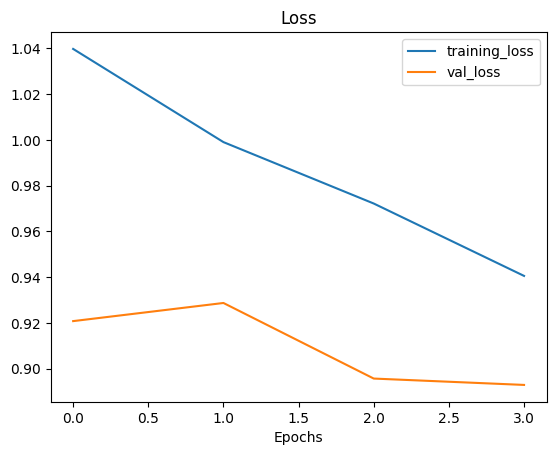

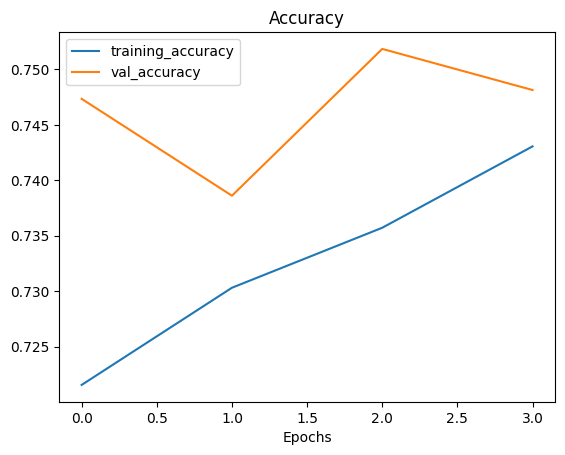

In [ ]:
plot_loss_curves(hist)

In [ ]:
model.save('drive/MyDrive/Models/big_fintetuned.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loaded_model = tf.keras.models.load_model('drive/MyDrive/Models/big_fintetuned.h5')
res_loaded = loaded_model.evaluate(test_data)

790/790 [==============================] - 61s 74ms/step - loss: 0.9031 - accuracy: 0.7516


In [ ]:
model = tf.keras.models.load_model('drive/MyDrive/Models/big_fintetuned.h5')
res = model.evaluate(test_data)

790/790 [==============================] - 63s 67ms/step - loss: 0.9031 - accuracy: 0.7516


In [ ]:
model.layers[2].trainable = True
for layer in model.layers[2].layers:
  print(layer.name, ':', layer.trainable)

input_1 : True
rescaling : True
normalization : True
stem_conv : True
stem_bn : True
stem_activation : True
block1a_project_conv : True
block1a_project_bn : True
block1a_project_activation : True
block2a_expand_conv : True
block2a_expand_bn : True
block2a_expand_activation : True
block2a_project_conv : True
block2a_project_bn : True
block2b_expand_conv : True
block2b_expand_bn : True
block2b_expand_activation : True
block2b_project_conv : True
block2b_project_bn : True
block2b_drop : True
block2b_add : True
block3a_expand_conv : True
block3a_expand_bn : True
block3a_expand_activation : True
block3a_project_conv : True
block3a_project_bn : True
block3b_expand_conv : True
block3b_expand_bn : True
block3b_expand_activation : True
block3b_project_conv : True
block3b_project_bn : True
block3b_drop : True
block3b_add : True
block4a_expand_conv : True
block4a_expand_bn : True
block4a_expand_activation : True
block4a_dwconv2 : True
block4a_bn : True
block4a_activation : True
block4a_se_squeeze

In [ ]:
for layer in model.layers[2].layers[:-25]:
  layer.trainable = False

for layer in model.layers[2].layers:
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
stem_conv False
stem_bn False
stem_activation False
block1a_project_conv False
block1a_project_bn False
block1a_project_activation False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_project_conv False
block2b_project_bn False
block2b_drop False
block2b_add False
block3a_expand_conv False
block3a_expand_bn False
block3a_expand_activation False
block3a_project_conv False
block3a_project_bn False
block3b_expand_conv False
block3b_expand_bn False
block3b_expand_activation False
block3b_project_conv False
block3b_project_bn False
block3b_drop False
block3b_add False
block4a_expand_conv False
block4a_expand_bn False
block4a_expand_activation False
block4a_dwconv2 False
block4a_bn False
block4a_activation False
block4a_se_squeeze False
block4a_se_reshape False
block4a

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
hist = model.fit(train_data,
                 epochs=20,
                 steps_per_epoch=len(train_data),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 initial_epoch=16)

Epoch 17/20
2368/2368 [==============================] - 667s 269ms/step - loss: 0.9196 - accuracy: 0.7501 - val_loss: 0.8878 - val_accuracy: 0.7567
Epoch 18/20
2368/2368 [==============================] - 379s 159ms/step - loss: 0.8674 - accuracy: 0.7613 - val_loss: 0.8827 - val_accuracy: 0.7594
Epoch 19/20
2368/2368 [==============================] - 345s 145ms/step - loss: 0.8224 - accuracy: 0.7723 - val_loss: 0.8853 - val_accuracy: 0.7595
Epoch 20/20
2368/2368 [==============================] - 308s 129ms/step - loss: 0.7809 - accuracy: 0.7810 - val_loss: 0.8961 - val_accuracy: 0.7554


In [ ]:
red = model.evaluate(test_data)

790/790 [==============================] - 55s 69ms/step - loss: 0.8961 - accuracy: 0.7554


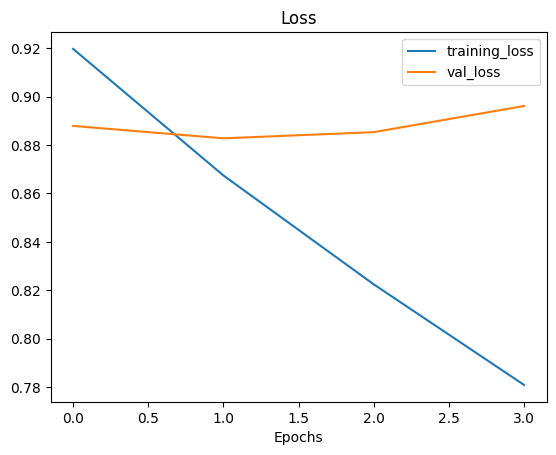

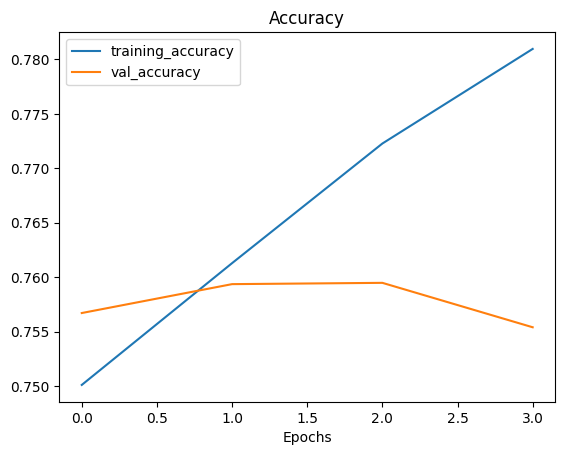

In [ ]:
plot_loss_curves(hist)

In [ ]:
model.save('drive/MyDrive/Models/big_fintetuned.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loaded_model = tf.keras.models.load_model('drive/MyDrive/Models/big_fintetuned.h5')
res_loaded = loaded_model.evaluate(test_data)

790/790 [==============================] - 53s 65ms/step - loss: 0.8961 - accuracy: 0.7554


In [ ]:
model = tf.keras.models.load_model('drive/MyDrive/Models/big_fintetuned.h5')

### **Predictions**

In [ ]:
def load_and_prep_img(filepath, img_shape=224, scale=False):
  '''
  get image from filepath, img_size and scaling can be specified
  outputs image
  '''
  img = tf.io.read_file(filepath)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, [img_shape, img_shape])

  if scale:
    img = img/255.

  return img

In [ ]:
import matplotlib.pyplot as plt

def predict_for(filepath):
  img = load_and_prep_img(filepath)
  pred = model.predict(tf.expand_dims(img, axis=0))
  class_name = pred.argmax()
  likeliness = pred.max()
  plt.imshow(img/255.)
  plt.title(f'prediction: {class_names[class_name]}\nprobability: {likeliness:.2f}')
  plt.axis(False);


1/1 [==============================] - 3s 3s/step


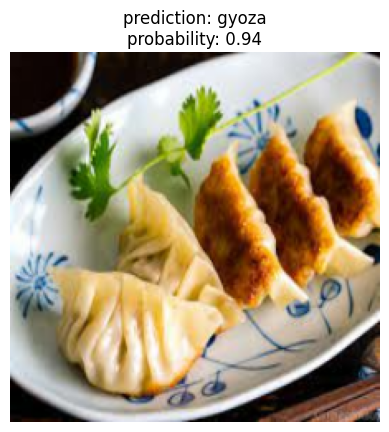

In [ ]:
predict_for('gyoza.jpeg')